In [20]:
import ufl
from ufl import  TrialFunction, TestFunction, FacetNormal, lhs, rhs,SpatialCoordinate

import dolfinx
from dolfinx import mesh, fem, io, nls, log
from dolfinx.fem import FunctionSpace, VectorFunctionSpace
from dolfinx.fem.petsc import LinearProblem, NonlinearProblem

from mpi4py import MPI
import petsc4py.PETSc
import numpy as np
import matplotlib.pyplot as plt


# Operators:
class Infix:

    def __init__(self, function):
        self.function = function

    def __ror__(self, other):
        return Infix(lambda x, self=self, other=other: self.function(other, x))

    def __or__(self, other):
        return self.function(other)

    def __call__(self, value1, value2):
        return self.function(value1, value2)


from ufl import sym, tr
from ufl import exp, sqrt

dot = Infix(ufl.inner)
from ufl import dx, ds, exp
from ufl import nabla_div as div
from ufl import nabla_grad as grad

npor = Infix(np.logical_or)
npand = Infix(np.logical_and)


def I(func_like):
    """Create matrix Identity dimension of func_like

    Args:
        func_like (Function): Give geometric dimension

    Returns:
        Tensor: Identity
    """
    return ufl.Identity(func_like.geometric_dimension())


# Classes:
def Function(space, func=None):
    """function function on new space. 
    Default create just Function on space

    Args:
        space (FunctionSpace): New space
        function (): Any function

    Returns:
        fem.Function: Function
    """
    if func == None: return fem.Function(space)

    func2 = fem.Function(space)
    if hasattr(func, 'ufl_domain'):
        expression = fem.Expression(func, space.element.interpolation_points())
    else:
        expression = func

    func2.interpolate(expression)
    return func2


def Constant(space, const):
    """Constant on space

    Args:
        space (FunctionSpace): Space
        const (auny number): Any number

    Returns:
        Constant: Constant on
    """
    return fem.Constant(space, petsc4py.PETSc.ScalarType(const))


def create_facet_markers(bound_markers, domain):
    """Mark facets under conditious

    Args:
        bound_markers (tuple): List of mark and function
        domain (Domain): Domain
    """
    facet_indices, facet_markers = [], []
    for (marker, condition) in bound_markers:
        facets = mesh.locate_entities(
            domain,
            domain.topology.dim - 1,
            condition,
            )
        facet_indices.append(facets)
        facet_markers.append(np.full_like(facets, marker))
    facet_indices = np.hstack(facet_indices).astype(np.int32)
    facet_markers = np.hstack(facet_markers).astype(np.int32)
    sorted_facets = np.argsort(facet_indices)
    facet_tags = mesh.meshtags(
        domain,
        domain.topology.dim - 1,
        facet_indices[sorted_facets],
        facet_markers[sorted_facets],
        )

    return facet_tags


def create_connectivity(domain):
    """Need to compute facets to Boundary value

    Args:
        domain (Mesh): Domain
    """
    domain.topology.create_connectivity(
        domain.topology.dim - 1,
        domain.topology.dim,
        )


def DirichletBC(space, func, combined_marker):
    """Create Dirichlet condition

    Args:
        space (FunctionSpace): Function space
        func (Function): Function
        combined_marker (Any): One from next
        \nFunction - boundary marker function
        \nAll - all boundary
        \n(Marked_facets, marker) - list or tuple, marker of boundary from Marked_facets
        
    Returns:
        condition (dirichletbc): Dirichlet condition
    """

    def get_exterior_facets():
        exterior_facets = mesh.exterior_facet_indices(domain.topology)
        return exterior_facets

    def all_dirichlet(dofs, func):
        if hasattr(func, 'function_space'):
            bc = fem.dirichletbc(dofs=dofs, value=func)
        else:
            bc = fem.dirichletbc(V=space, dofs=dofs, value=func)
        return bc

    domain = space.mesh

    if combined_marker == 'All':
        facets = get_exterior_facets()
        dofs = fem.locate_dofs_topological(
            space,
            domain.topology.dim - 1,
            facets,
            )

    elif type(combined_marker) == list:
        marked_facets, marker = combined_marker
        facets = marked_facets.find(marker)
        dofs = fem.locate_dofs_topological(
            space,
            domain.topology.dim - 1,
            facets,
            )
    else:
        dofs = fem.locate_dofs_geometrical(space, marker=combined_marker)

    bc = all_dirichlet(dofs, func)

    return bc


# Post processing:
def get_L_errors(uS, uEx):
    """Compute error norm on boundary

    Args:
        uS (Function): Numeric solution
        uEx (Function): Exact or model solution

    Returns:
        List: L1 and L2 norms
    """
    domain = uS.function_space.mesh

    V_err = FunctionSpace(
        domain,
        ('CG', uS.function_space.element.space_dimension),
        )
    uEx = Function(V_err, uEx)
    L1_scalar = fem.assemble_scalar(form((uS-uEx) * dx))
    L2_scalar = fem.assemble_scalar(form((uS - uEx)**2 * dx))

    L1_err = np.abs(domain.comm.allreduce(L1_scalar, op=MPI.SUM))
    L2_err = np.sqrt(domain.comm.allreduce(L2_scalar, op=MPI.SUM))
    return (L1_err, L2_err)


def line_collision(domain, line_cord):
    """Generate points and cells of colliding domain and line

    Args:
        domain (mesh): Domain
        line_cord (array): 3D line contervertor of coordinates 

    Returns:
        Tuple: Collision points and collision cells
    """
    bb_tree = dolfinx.geometry.BoundingBoxTree(domain, domain.topology.dim)

    cells_on_line = []
    points_on_line = []
    cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, line_cord.T)
    colliding_cells = dolfinx.geometry.compute_colliding_cells(
        domain, cell_candidates, line_cord.T
        )
    for i, point in enumerate(line_cord.T):
        if len(colliding_cells.links(i)) > 0:
            points_on_line.append(point)
            cells_on_line.append(colliding_cells.links(i)[0])

    points_on_line = np.array(points_on_line, dtype=np.float64)

    return (points_on_line, cells_on_line)


def graph2D(fig, lists, natural_show=False, points_on=False):
    """_summary_

    Args:
        fig (plt.Figure): Figure
        lists (u , ax, title): List of arguments
        natural_show (bool, optional): True= tripcolor, False= tricontourf. Defaults to False.
        points_on (bool, optional): Show points. Defaults to False.
    """

    def data_construct(dofs, x_array):
        data = np.column_stack((dofs[:, 0:2], x_array))
        x_data = data[:, 0]
        y_data = data[:, 1]
        z_data = data[:, 2]
        return [x_data, y_data, z_data]

    for list in lists:
        u, ax, title = list
        dofs = u.function_space.tabulate_dof_coordinates()
        ax.set_title(title)
        data = data_construct(dofs, u.x.array)

        if points_on: ax.plot(data[0], data[1], 'o', markersize=2, color='grey')

        if natural_show:
            plot = ax.tripcolor(*data)
        else:
            try:
                levels = np.linspace(u.x.array.min(), u.x.array.max(), 10)
                plot = ax.tricontourf(
                    *data,
                    levels=levels,
                    )
            except:
                print(f'{title} - error')
                plot = ax.tricontourf(*data)

        ax.set_aspect(1)
        fig.colorbar(plot, ax=ax)
    return

In [23]:
N = 10
T = 1
Nt = 11
dt = T/Nt
domain = mesh.create_rectangle(
    comm=MPI.COMM_WORLD,
    points=[[-1,1],[1,1]],
    n=[10,10],
    cell_type=mesh.CellType.quadrilateral,
    )
create_connectivity(domain=domain)
V =FunctionSpace(domain, ('CG', 1))

u, v = TrialFunction(V), TestFunction(V)
x, y = SpatialCoordinate(V)
ds = ufl.Measure("ds", domain=domain)
dx = ufl.Measure('cell', subdomain_id='everywhere')

f = Constant(V,0)
uD= Constant(V,1)
a = Constant(V,5)
u0 = Function(V,-5*(x**2+y**2))



bcs = [
    DirichletBC(
        space=V,
        func=uD,
        combined_marker='All',
        ),
    ]

F = u*v * dx + dt * (grad(u) |dot| grad(v)) * dx - dt *f*v * dx - u0*v*dx

In [16]:
bilinear_form = fem.form(form=lhs(F))
A = fem.petsc.assemble_matrix(bilinear_form,bcs)

solver = petsc4py.PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(petsc4py.PETSc.KSP.Type.PREONLY)
solver.getPC().setType(petsc4py.PETSc.PC.Type.LU)

AttributeError: 'Constant' object has no attribute 'function_space'

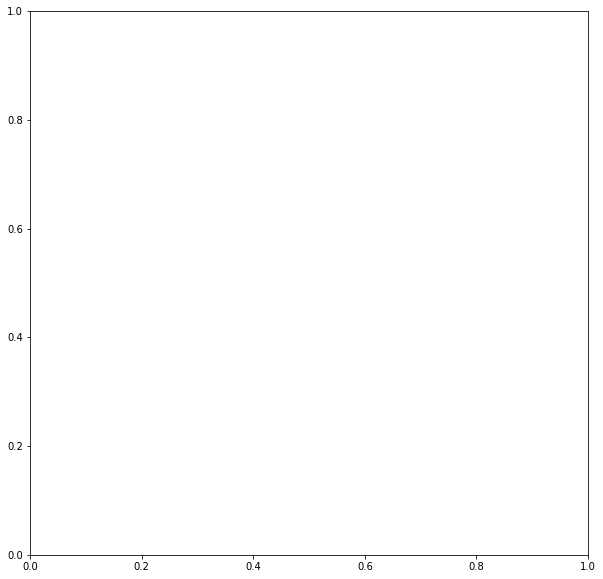

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
graph2D(
    fig=fig,
    lists=[
        [f, ax, 'u0'],
        ],
    natural_show=True,
    )


In [ ]:
for t in np.range(0,T+dt,dt):
    


SyntaxError: incomplete input (2236182148.py, line 2)

In [ ]:
s= sigma(uS) - 1/3 * tr(sigma(uS))*I(uS)
estress = sqrt(3/2 * (s|dot|s))

V_von = FunctionSpace(domain,('DG',0))
stress = Function(V_von, estress)

In [ ]:
# with io.XDMFFile (
#     domain.comm,
#     'Heat-Files/heat.xdmf',
#     'w'
# ) as file:
#     file.write_mesh(domain)
#     uS.name = 'Deformation'
#     file.write_function(uS)
#     stress.name = 'Stress von Mises'
#     file.write_function(stress)